In [2]:
%matplotlib inline
# Beat tracking example
import librosa
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# We'll need the os module for file path manipulation
import os
from os import walk

# And seaborn to make it look nice
import seaborn
seaborn.set(style='ticks')

# and IPython.display for audio output
import IPython.display


import matplotlib as mpl


from sklearn import datasets
from sklearn.cross_validation import StratifiedKFold
from sklearn.externals.six.moves import xrange
from sklearn.mixture import GMM

import sys
sys.path.append('src/')

import utils

In [3]:
reload(utils)

<module 'utils' from 'src/utils.pyc'>

In [4]:
#load DataFrame to merge features with eventually
DF_to_merge = pd.read_csv("/Users/mayarotmensch/Google_Drive/DSGA1003 - Project/Data/Final_Data/Master_4.26.15.csv")

In [5]:
#DF_to_merge.Filename
#DF_to_merge2 = pd.read_csv("/Users/mayarotmensch/Google Drive/DSGA1003 - Project/Data/Final_Data/Combined_Master.csv")

In [6]:
print list(DF_to_merge.Filename.unique())

['1998_96_1570_brown_u_r_n_m', '1998_96_1570_young_u_p_f_m', '1998_96_1793_oelschlaeger_u_r_f_m', '1998_96_1793_seitz_u_p_n_f', '1998_97_1008_morrison_u_r_n_m', '1998_97_1008_roberts_u_acp_i_m', '1998_97_1008_wall_u_p_f_m', '1998_97_1056_geffner_u_r_f_m', '1998_97_1056_lajeunesse_u_p_n_m', '1998_97_1121_grossman_u_r_f_m', '1998_97_1121_rosenthal_s_p_n_m', '1998_97_1130_bain_u_r_f_m', '1998_97_1130_minear_u_acr_i_m', '1998_97_1130_selinger_u_p_n_m', '1998_97_1139_mcdonald_u_r_n_m', '1998_97_1139_wolfson_u_p_f_m', '1998_97_1184_gornstein_u_r_n_m', '1998_97_1184_oduden_u_p_f_m', '1998_97_1184_smith_u_p_f_m', '1998_97_1230_smith_u_r_n_m', '1998_97_1230_sutton_u_acp_i_m', '1998_97_1235_berger_u_r_f_m', '1998_97_1235_kneedler_u_acp_i_m', '1998_97_1235_yuhas_u_p_n_m', '1998_97_1252_cole_s_r_n_m', '1998_97_1252_stewart_u_p_f_m', '1998_97_1287_blatt_s_acp_i_f', '1998_97_1287_cappuccio_s_p_f_m', '1998_97_1287_kupferberg_u_r_n_m', '1998_97_1396_avila_u_p_f_m', '1998_97_1396_stone_u_r_n_m', '1998_

In [7]:
#valid_files_names_female
#q = 'male/1998_97_1868_kayatta_u_p_n_m.wav'
#'male/1998_97_1868_kayatta_u_p_n_m.wav' in valid_files_names_male
#valid_files_names_female

In [8]:
#set(b1).intersection(b2)
#set(valid_files_names_female).intersection(DF_to_merge.Filename)
#set(DF_to_merge.Filename).intersection(set(['1998_96_1570_young_u_p_f_m']))
#set(DF_to_merge.Filename).intersection(set(valid_files_names))


In [22]:
#get female files
path_female = "/Users/mayarotmensch/Google_Drive/DSGA1003 - Project/Data/original/female/"
y_series_female, sr_series_female,valid_files_names_female = utils.GetAudio(path_female)

#get male files
path_male = "/Users/mayarotmensch/Google_Drive/DSGA1003 - Project/Data/original/male/"
y_series_male, sr_series_male,valid_files_names_male = utils.GetAudio(path_male)


In [23]:
len(y_series_male)

1949

In [24]:
#parent file information
'''valid_files_names_female = ["female/"+file_name for file_name in valid_files_names_female]
valid_files_names_male = ["male/"+file_name for file_name in valid_files_names_male]'''

valid_files_names_female = [file_name[:-4] for file_name in valid_files_names_female]
valid_files_names_male = [file_name[:-4] for file_name in valid_files_names_male]

valid_files_names = valid_files_names_female+valid_files_names_male
#concatenate male+female information
sr = sr_series_male[0] # analysis has shows that all audio was samples at 22050.
y_series = y_series_female+y_series_male

In [27]:
# make sure we have all appropriate files loaded correctly
assert len(set(DF_to_merge.Filename).difference(set(valid_files_names))) == 0

In [28]:
hop_length = 512

In [29]:
## create dataframe into which we load all our new features
Acoustic_Data = pd.DataFrame(valid_files_names, columns = ["Audio"])
Acoustic_Data.set_index(Acoustic_Data.Audio, inplace = True)

# ** Onset Features **

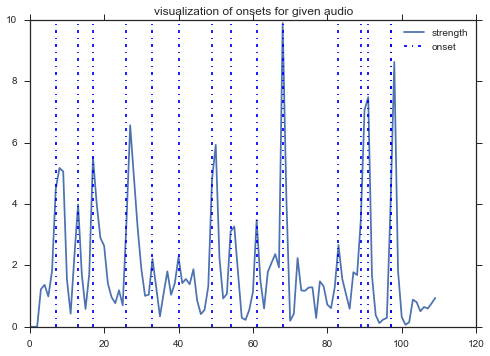

In [34]:
########## Visualization ########## 
detected_onset = librosa.onset.onset_detect(y=y_series[2],sr=sr,hop_length=hop_length)
onset_strengths = librosa.onset.onset_strength(y=y_series[2],sr=sr,hop_length=hop_length)

plt.plot(onset_strengths, label = "strength")
for d in detected_onset:
    plt.axvline(x=d, ymin=0, ymax=10,linestyle = '-.')

plt.axvline(x=detected_onset[-1], ymin=0, ymax=10,linestyle = '-.', label = "onset")
plt.title("visualization of onsets for given audio")
plt.legend()
plt.savefig("figures/onsets")


In [35]:
########## Features extraction ########## 
# onsets could also serve as a proxy for how many pauses the speaker takes.

def NumberOfOnsets(y_series, valid_files_names, DF, sr = sr):
    ''' change DF not inplace '''
    DF_copy = DF.copy()
    ## number of detected onsets
    for i,clip in enumerate(y_series):
        detected_onset = librosa.onset.onset_detect(y=clip,sr=sr,hop_length=hop_length)
        DF_copy.loc[valid_files_names[i],'onset_number'] = len(detected_onset)
    return DF_copy

In [36]:
Acoustic_Data = NumberOfOnsets(y_series= y_series, valid_files_names = valid_files_names, DF = Acoustic_Data, sr = sr)
Acoustic_Data.drop("Audio",1, inplace = True)

In [37]:
def OnsetStrengthChar(y_series, valid_files_names, DF, sr = sr):
    """ Charecteristics of onsets
    Args:
    
    Returns:
        max
        min
        mean
    """ 
    DF_copy = DF.copy()
    ## strength of detected onsets
    for i,clip in enumerate(y_series):        
        onset_strengths = librosa.onset.onset_strength(y=clip,sr=sr,hop_length=hop_length)
        DF_copy.loc[valid_files_names[i],'onset_strength_max'] = np.max(onset_strengths)
        DF_copy.loc[valid_files_names[i],'onset_strength_mean'] = np.mean(onset_strengths)
        DF_copy.loc[valid_files_names[i],'onset_strength_var'] = np.var(onset_strengths)
    return DF_copy
    

In [38]:
Acoustic_Data = OnsetStrengthChar(y_series=y_series, valid_files_names=valid_files_names, DF=Acoustic_Data)

# RMSE Feature

In [39]:
## Compute root-mean-square (RMS) energy for each frame.
## charecterizes "loudness"

def RSME(y_series, valid_files_names, DF):
    DF_copy = DF.copy()
    ## number of detected onsets
    for i,clip in enumerate(y_series):   
        DF_copy.loc[valid_files_names[i],'RMSE_max'] = np.mean(librosa.feature.rmse(y=clip))
        DF_copy.loc[valid_files_names[i],'RMSE_var'] = np.var(librosa.feature.rmse(y=clip))
    return DF_copy
    


In [40]:
Acoustic_Data = RSME(y_series=y_series, valid_files_names = valid_files_names, DF = Acoustic_Data)

In [41]:
Acoustic_Data.head(10)

,onset_number,onset_strength_max,onset_strength_mean,onset_strength_var,RMSE_max,RMSE_var
Audio,,,,,,
1998_96_1793_seitz_u_p_n_f,13,5.854709,1.757330,1.498846,1.458002,0.936990
1998_97_1287_blatt_s_acp_i_f,16,5.716841,1.846490,1.563648,1.554305,0.631686
1998_97_1418_millet_u_acp_i_f,14,9.896725,1.929223,3.510807,1.386466,1.130075
1998_97_1489_blatt_u_r_f_f,15,6.631968,1.868234,2.193339,1.459234,0.929881
1998_97_1489_gustin_u_p_n_f,17,6.299992,1.604102,1.073664,1.525704,0.737032
1998_97_1536_brinkman_u_acp_i_f,18,7.244723,1.938533,2.251241,1.421778,1.020848
1998_97_1754_millett_u_p_f_f,14,7.040922,1.871312,1.850027,1.409115,1.069015
1998_97_1754_wetts_u_r_n_f,14,5.707790,1.815444,1.562136,1.537557,0.670088
1998_97_1909_smith_u_p_n_f,17,5.897089,1.745992,1.489806,1.394035,1.103257


# Chromagram

In [42]:
# We'll use a CQT-based chromagram here.  An STFT-based implementation also exists in chroma_cqt()
# We'll use the harmonic component to avoid pollution from transients
#C = librosa.feature.chroma_cqt(y=y_series[3], sr=sr)

'''
# Make a new figure
plt.figure(figsize=(12,4))

# Display the chromagram: the energy in each chromatic pitch class as a function of time
# To make sure that the colors span the full range of chroma values, set vmin and vmax
librosa.display.specshow(C, sr=sr, x_axis='time', y_axis='chroma', vmin=0, vmax=1)

plt.title('Chromagram')
plt.colorbar()

plt.tight_layout()'''

"\n# Make a new figure\nplt.figure(figsize=(12,4))\n\n# Display the chromagram: the energy in each chromatic pitch class as a function of time\n# To make sure that the colors span the full range of chroma values, set vmin and vmax\nlibrosa.display.specshow(C, sr=sr, x_axis='time', y_axis='chroma', vmin=0, vmax=1)\n\nplt.title('Chromagram')\nplt.colorbar()\n\nplt.tight_layout()"

In [43]:
def PitchMetrics(y_series, valid_files_names, DF, sr = sr):
    DF_copy = DF.copy()
    for i,clip in enumerate(y_series):   
        C = librosa.feature.chroma_cqt(y=clip, sr=sr)
        for j in range(C.shape[0]):
            DF_copy.loc[valid_files_names[i],'Pitch_%s' %j] = np.mean(C[j,:])
            #print mean
    return DF_copy

    

In [44]:
NEW = PitchMetrics(y_series=y_series, valid_files_names = valid_files_names, DF = Acoustic_Data)

In [46]:
NEW.head()

,onset_number,onset_strength_max,onset_strength_mean,onset_strength_var,RMSE_max,RMSE_var,Pitch_0,Pitch_1,Pitch_2,Pitch_3,Pitch_4,Pitch_5,Pitch_6,Pitch_7,Pitch_8,Pitch_9,Pitch_10,Pitch_11
Audio,,,,,,,,,,,,,,,,,,
1998_96_1793_seitz_u_p_n_f,13,5.854709,1.757330,1.498846,1.458002,0.936990,0.574348,0.568631,0.515068,0.591022,0.533305,0.459878,0.495243,0.485591,0.421840,0.396215,0.411003,0.365309
1998_97_1287_blatt_s_acp_i_f,16,5.716841,1.846490,1.563648,1.554305,0.631686,0.474540,0.504153,0.473202,0.492053,0.388192,0.378821,0.492952,0.632042,0.673775,0.499150,0.429502,0.363781
1998_97_1418_millet_u_acp_i_f,14,9.896725,1.929223,3.510807,1.386466,1.130075,0.636672,0.644117,0.647330,0.514262,0.456698,0.396259,0.381926,0.368830,0.374476,0.501599,0.383126,0.391440
1998_97_1489_blatt_u_r_f_f,15,6.631968,1.868234,2.193339,1.459234,0.929881,0.577103,0.540580,0.423197,0.428155,0.431954,0.516822,0.523793,0.593789,0.557094,0.584877,0.529765,0.437058
1998_97_1489_gustin_u_p_n_f,17,6.299992,1.604102,1.073664,1.525704,0.737032,0.475306,0.512333,0.448028,0.374256,0.389251,0.398331,0.548889,0.572904,0.427061,0.493102,0.459444,0.383952


In [47]:
Added_DF = pd.merge(DF_to_merge, NEW, how='left', left_on='Filename', right_on=None,
          left_index=False, right_index=True, copy=True)

In [63]:
Added_DF=Added_DF.drop(["Unnamed: 0"],1)
Added_DF.to_csv("Master_27_4.csv")

In [64]:
pd.read_csv("Master_27_4.csv")


,Unnamed: 0,WorkerId,Filename,AssignmentId,Aggressive,Attractive,Confident,Intelligent,Masculine,Quality,...,Pitch_2,Pitch_3,Pitch_4,Pitch_5,Pitch_6,Pitch_7,Pitch_8,Pitch_9,Pitch_10,Pitch_11
0,0,A1EB857G7CK9K9,1998_96_1570_brown_u_r_n_m,3B3WTRP3DB2DXOPUGOJUSOPRSHS92C,2,3,4,5,3,5,...,0.644422,0.655973,0.604729,0.651543,0.580218,0.494154,0.488906,0.555120,0.503023,0.447732
1,1,A380PU6ZH8UEBV,1998_96_1570_brown_u_r_n_m,3P59JYT76LKWH3Y8EUOBJOQ3N4ET2C,4,4,5,4,7,7,...,0.644422,0.655973,0.604729,0.651543,0.580218,0.494154,0.488906,0.555120,0.503023,0.447732
2,2,A37WQ2HYE1M86A,1998_96_1570_brown_u_r_n_m,3LWJHTCVCCM3QHISLL9NY295BPPQFV,5,3,6,2,6,5,...,0.644422,0.655973,0.604729,0.651543,0.580218,0.494154,0.488906,0.555120,0.503023,0.447732
3,3,A1DCA3FSX06H6F,1998_96_1570_brown_u_r_n_m,3E4GGUZ1T8RXEK8LKLAJIX374RZK29,4,3,4,5,6,7,...,0.644422,0.655973,0.604729,0.651543,0.580218,0.494154,0.488906,0.555120,0.503023,0.447732
4,4,A2XCEA0G25DT6W,1998_96_1570_brown_u_r_n_m,3GNA64GUZE4BOKP3F9WECQISN1FQ5T,5,5,5,5,6,6,...,0.644422,0.655973,0.604729,0.651543,0.580218,0.494154,0.488906,0.555120,0.503023,0.447732
5,5,A25FV5NFFE0PAI,1998_96_1570_brown_u_r_n_m,3DYGAII7PL8FHU7MZO5SAWN9DVFQP1,2,4,3,6,6,3,...,0.644422,0.655973,0.604729,0.651543,0.580218,0.494154,0.488906,0.555120,0.503023,0.447732
6,6,A11N8D0L560PVJ,1998_96_1570_brown_u_r_n_m,3EQHHY4HQSSKBVVPCDR2ICEQG9CG5J,4,5,5,5,6,6,...,0.644422,0.655973,0.604729,0.651543,0.580218,0.494154,0.488906,0.555120,0.503023,0.447732
7,7,A3EPBFTXWBRHVY,1998_96_1570_brown_u_r_n_m,3Z2R0DQ0JHEUSKGBOZZGK2Q2JE02E7,3,3,3,3,4,6,...,0.644422,0.655973,0.604729,0.651543,0.580218,0.494154,0.488906,0.555120,0.503023,0.447732
8,8,A2SMAZGQOV2IAU,1998_96_1570_brown_u_r_n_m,36U2A8VAG1ZNF51SD6HER14CIQGKYF,7,5,6,6,7,7,...,0.644422,0.655973,0.604729,0.651543,0.580218,0.494154,0.488906,0.555120,0.503023,0.447732
9,9,A2Y0SIZH81B265,1998_96_1570_brown_u_r_n_m,34V1S5K3GS11FP8V3QVXI1638RM69S,6,4,6,6,7,6,...,0.644422,0.655973,0.604729,0.651543,0.580218,0.494154,0.488906,0.555120,0.503023,0.447732


In [158]:
from sklearn import datasets 
from sklearn.mixture import GMM
iris = datasets.load_iris()

In [153]:
from sklearn import datasets
from sklearn.cross_validation import StratifiedKFold

In [154]:
skf = StratifiedKFold(iris.target, n_folds=4)
# Only take the first fold.
train_index, test_index = next(iter(skf))


X_train = iris.data[train_index]
y_train = iris.target[train_index]

In [155]:
iris.data.shape

(150, 4)

In [161]:
X_train.shape
n_classes = len(np.unique(y_train))

In [162]:
# Try GMMs using different types of covariances.
classifiers = dict((covar_type, GMM(n_components=n_classes,
                    covariance_type=covar_type, init_params='wc', n_iter=20))
                   for covar_type in ['spherical', 'diag', 'tied', 'full'])



# MFCC

In [174]:
mfccs = librosa.feature.mfcc(y=y_series[0], sr=sr,n_mfcc=39)

In [176]:
mfcc_matrix = mfccs.T
mfcc_train = 

g = mixture.GMM(n_components=2)
g.fit(mfcc_matrix) 
GMM(covariance_type='diag', init_params='wmc', min_covar=0.001,
        n_components=2, n_init=1, n_iter=100, params='wmc',
        random_state=None, thresh=None, tol=0.001)

np.round(g.weights_, 2)



(100, 39)

In [ ]:
'''covariance_type='diag', init_params='wmc', min_covar=0.001,
        n_components=2, n_init=1, n_iter=100, params='wmc',
        random_state=None, thresh=None, tol=0.001)
>>> np.round(g.weights_, 2)
array([ 0.75,  0.25])
>>> np.round(g.means_, 2)
array([[ 10.05],
       [  0.06]])
>>> np.round(g.covars_, 2) 
array([[[ 1.02]],
       [[ 0.96]]])
>>> g.predict([[0], [2], [9], [10]]) 
array([1, 1, 0, 0]...)
>>> np.round(g.score([[0], [2], [9], [10]]), 2)
array([-2.19, -4.58, -1.75, -1.21])
>>> # Refit the model on new data (initial parameters remain the
>>> # same), this time with an even split between the two modes.
>>> g.fit(20 * [[0]] +  20 * [[10]]) 
GMM(covariance_type='diag', init_params='wmc', min_covar=0.001,
        n_components=2, n_init=1, n_iter=100, params='wmc',
        random_state=None, thresh=None, tol=0.001)
>>> np.round(g.weights_, 2)
array([ 0.5,  0.5])'''

In [167]:


'''
def make_ellipses(gmm, ax):
    for n, color in enumerate('rgb'):
        v, w = np.linalg.eigh(gmm._get_covars()[n][:2, :2])
        u = w[0] / np.linalg.norm(w[0])
        angle = np.arctan2(u[1], u[0])
        angle = 180 * angle / np.pi  # convert to degrees
        v *= 9
        ell = mpl.patches.Ellipse(gmm.means_[n, :2], v[0], v[1],
                                  180 + angle, color=color)
        ell.set_clip_box(ax.bbox)
        ell.set_alpha(0.5)
        ax.add_artist(ell)

iris = datasets.load_iris()

# Break up the dataset into non-overlapping training (75%) and testing
# (25%) sets.
skf = StratifiedKFold(iris.target, n_folds=4)
# Only take the first fold.
train_index, test_index = next(iter(skf))


X_train = iris.data[train_index]
y_train = iris.target[train_index]
X_test = iris.data[test_index]
y_test = iris.target[test_index]

n_classes = len(np.unique(y_train))

# Try GMMs using different types of covariances.
classifiers = dict((covar_type, GMM(n_components=n_classes,
                    covariance_type=covar_type, init_params='wc', n_iter=20))
                   for covar_type in ['spherical', 'diag', 'tied', 'full'])

n_classifiers = len(classifiers)

plt.figure(figsize=(3 * n_classifiers / 2, 6))
plt.subplots_adjust(bottom=.01, top=0.95, hspace=.15, wspace=.05,
                    left=.01, right=.99)


for index, (name, classifier) in enumerate(classifiers.items()):
    # Since we have class labels for the training data, we can
    # initialize the GMM parameters in a supervised manner.
    classifier.means_ = np.array([X_train[y_train == i].mean(axis=0)
                                  for i in xrange(n_classes)])

    # Train the other parameters using the EM algorithm.
    classifier.fit(X_train)

    h = plt.subplot(2, n_classifiers / 2, index + 1)
    make_ellipses(classifier, h)

    for n, color in enumerate('rgb'):
        data = iris.data[iris.target == n]
        plt.scatter(data[:, 0], data[:, 1], 0.8, color=color,
                    label=iris.target_names[n])
    # Plot the test data with crosses
    for n, color in enumerate('rgb'):
        data = X_test[y_test == n]
        plt.plot(data[:, 0], data[:, 1], 'x', color=color)

    y_train_pred = classifier.predict(X_train)
    train_accuracy = np.mean(y_train_pred.ravel() == y_train.ravel()) * 100
    plt.text(0.05, 0.9, 'Train accuracy: %.1f' % train_accuracy,
             transform=h.transAxes)

    y_test_pred = classifier.predict(X_test)
    test_accuracy = np.mean(y_test_pred.ravel() == y_test.ravel()) * 100
    plt.text(0.05, 0.8, 'Test accuracy: %.1f' % test_accuracy,
             transform=h.transAxes)

    plt.xticks(())
    plt.yticks(())
    plt.title(name)

plt.legend(loc='lower right', prop=dict(size=12))


plt.show()'''


"\ndef make_ellipses(gmm, ax):\n    for n, color in enumerate('rgb'):\n        v, w = np.linalg.eigh(gmm._get_covars()[n][:2, :2])\n        u = w[0] / np.linalg.norm(w[0])\n        angle = np.arctan2(u[1], u[0])\n        angle = 180 * angle / np.pi  # convert to degrees\n        v *= 9\n        ell = mpl.patches.Ellipse(gmm.means_[n, :2], v[0], v[1],\n                                  180 + angle, color=color)\n        ell.set_clip_box(ax.bbox)\n        ell.set_alpha(0.5)\n        ax.add_artist(ell)\n\niris = datasets.load_iris()\n\n# Break up the dataset into non-overlapping training (75%) and testing\n# (25%) sets.\nskf = StratifiedKFold(iris.target, n_folds=4)\n# Only take the first fold.\ntrain_index, test_index = next(iter(skf))\n\n\nX_train = iris.data[train_index]\ny_train = iris.target[train_index]\nX_test = iris.data[test_index]\ny_test = iris.target[test_index]\n\nn_classes = len(np.unique(y_train))\n\n# Try GMMs using different types of covariances.\nclassifiers = dict((cova